
# Part 1: Hamiltonians and Operators

The goal of this tutorial series is to guide you through writing a simple VMC code from (almost) scratch to compute the ground-state of a paradigmatic spin model: the transverse-field Ising model in 2 dimensions.

In this first tutorial, we will focus on:
- Understanding NetKet's graph and operator system
- Defining Hamiltonians using building blocks
- Working with different operator formats
- Validating our implementation with exact diagonalization

The hamiltonian we will study is the transverse-field Ising model in 2 dimensions:

$$
\mathcal{H}=-h\sum_{i}\sigma_{i}^{(x)}+J\sum_{\langle i,j \rangle}\sigma_{i}^{(z)}\sigma_{j}^{(z)}.
$$

In the following we assume periodic boundary conditions with $h=1$ and $J=1$.

:::{note}
If you are executing this notebook on **Colab**, you will need to install NetKet.
You can do so by uncommenting and running the following cell.

Keep in mind that this notebook was designed for NetKet version `3.9.1`, which requires Python >=3.8.
:::

In [1]:
# %pip install --quiet netket

Please verify that you are running on the correct version of NetKet:

In [2]:
import platform
import netket as nk

print("Python version (requires >=3.9)", platform.python_version())
print("NetKet version (requires >=3.9.1)", nk.__version__)

Python version (requires >=3.9) 3.12.11
NetKet version (requires >=3.9.1) 3.19.dev26+gd94cf4597.d20250713


In [3]:
# Import necessary libraries
import netket as nk
import numpy as np

## 1. What is NetKet?

[NetKet](http://www.netket.org) is a comprehensive package developed to perform Variational Monte Carlo calculations, while hiding varying degrees of complexity from researchers who don't want to get their hands too dirty with nitty gritty details.

NetKet is thoroughly documented in [its publication](https://scipost.org/SciPostPhysCodeb.7/pdf) and partly in its [online documentation](https://netket.readthedocs.io/en/latest/index.html). When in doubt, check those, and if you find no answer, ask on our official [discussion forum](https://github.com/orgs/netket/discussions).

## 2. Defining Graphs and Lattices

NetKet covers quite a few standard lattices, so let's use this to quickly define a 2D square lattice with periodic boundary conditions.
For the moment we assume $L=4$ ($N=16$ sites total).

In [4]:
# Define a 2D square lattice
L = 4
g = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)

The graph object is handy to quickly write the hamiltonian because it gives you easy access to the vertices (called nodes) and edges of the graph:

In [5]:
# The number of sites (called nodes):
print("g.n_nodes:", g.n_nodes)
# You can iterate through the nodes:
print("g.nodes:", [node for node in g.nodes()])
# You can check the number of edges:
print("g.n_edges:", g.n_edges)
# You can iterate through the edges, which are stored as a 2-tuple with the start and end node:
print("g.edges:", list(g.edges()))

g.n_nodes: 16
g.nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
g.n_edges: 32
g.edges: [(3, 7), (12, 13), (8, 9), (8, 12), (2, 14), (13, 14), (4, 5), (5, 6), (4, 8), (12, 15), (5, 9), (14, 15), (3, 15), (8, 11), (0, 1), (9, 10), (1, 2), (0, 4), (9, 13), (10, 11), (1, 5), (10, 14), (6, 7), (6, 10), (4, 7), (0, 3), (0, 12), (2, 3), (1, 13), (2, 6), (11, 15), (7, 11)]


You can also visualize the lattice:

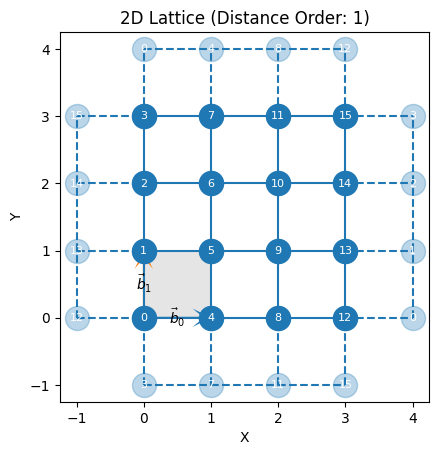

<Axes: title={'center': '2D Lattice (Distance Order: 1)'}, xlabel='X', ylabel='Y'>

In [6]:
g.draw()

## 3. Defining the Hilbert Space

Next, NetKet asks us to define the computational space (or basis) for this calculation.

In [7]:
# Define the Hilbert space based on this graph
# We have spin-1/2 particles on each site
hi = nk.hilbert.Spin(s=1 / 2, N=g.n_nodes)

This is a fundamental object that defines how many degrees of freedom you have and how you store configurations. In this case, the hilbert space stores them as local variables +1 or -1.

## 4. Building Operators

In NetKet you can build individual operators acting on a site by calling the following functions:

In [8]:
sx_1 = nk.operator.spin.sigmax(hi, 1)
sy_2 = nk.operator.spin.sigmay(hi, 2)
sz_2 = nk.operator.spin.sigmaz(hi, 2)

The functions in `nk.operator.spin` and `nk.operator.boson` are used to create the fundamental operators that can be used to build arbitrary observables and Hamiltonians.
Those functions return an object of type [LocalOperator](https://netket.readthedocs.io/en/latest/api/_generated/operator/netket.operator.LocalOperator.html#netket.operator.LocalOperator), which behaves as some sort of sparse matrix optimized for Variational Monte Carlo.

:::{note}
A `LocalOperator` can efficiently represent only operators that have a small domain in the computational basis: this means that an operator acting on 1 or 2 qubits will be efficiently represented, but one that acts on many qubits at once will not be.
:::

A LocalOperator can be printed and has the following representation:

In [9]:
print(sx_1)

LocalOperator(dim=16, acting_on=[(1,)], constant=0.0, dtype=float64)


The information tells you that:
 * `dim`: The hilbert space has 16 local degrees of freedom
 * `acting_on`: this specific operator is composed by terms that act on the single site 1
 * `constant`: this is a diagonal shift proportional to the identity. In this case it is 0
 * `dtype`: the numpy data-type of the matrix elements

## 5. Exercise: Building the Transverse Field Ising Hamiltonian

You can combine operators by multiplying, adding or subtracting them. Let's build the Transverse field Ising hamiltonian:

$$
\mathcal{H}=-h\sum_{i}\sigma_{i}^{(x)}+J\sum_{\langle i,j \rangle}\sigma_{i}^{(z)}\sigma_{j}^{(z)}.
$$

where $h=1$ and $J=1$.

Try to convert the equation above to code, using the operators that were discussed before (`nk.operator.spin.sigmax` and `nk.operator.spin.sigmaz`).

Complete the code below:


In [10]:
# This creates an empty operator (or zero) to which you can add others.
# hamiltonian = nk.operator.LocalOperator(hi)
#
# now add all terms acting on single sites
# for site in g.nodes():  # every node (take the list of nodes from the graph object g)
#     # TODO: Add the transverse field term -h * sigma_x
#     pass
#
# now add all terms acting on multiple sites
# for i, j in g.edges():  # every edge (take the list of edges from the graph object)
#     # TODO: Add the Ising interaction term J * sigma_z_i * sigma_z_j
#     pass

In [11]:
# This creates an empty operator to which you can add others.
hamiltonian = nk.operator.LocalOperator(hi)

# the list of nodes is given by g.nodes()
for site in g.nodes():
    hamiltonian = hamiltonian - 1.0 * nk.operator.spin.sigmax(hi, site)

for (i,j) in g.edges():
    # you can multiply operators by using the @ operator
    hamiltonian = hamiltonian + nk.operator.spin.sigmaz(hi, i)@nk.operator.spin.sigmaz(hi, j)

To check if your implementation is correct, you can run the following validation.
It will error if your implementation is wrong.

In [12]:
# Validation - test to verify your code is correct
hamiltonian_correct = nk.operator.Ising(hi, g, h=1.0, J=1.0)
assert np.sum(np.abs(hamiltonian_correct.to_sparse() - hamiltonian.to_sparse())**2) < 1e-5
print("Hamiltonian implementation is correct!")

Hamiltonian implementation is correct!


## 6. Converting Operator Formats

Most operators in NetKet are implemented in Numba and are not compatible with `jax.jit`. However, some particular operator formats are implemented both in `numba` and in a `jax.jit`-compatible format.

To make future tutorials easier, we will convert the operator to a JAX-friendly format. First we convert from the `LocalOperator` format to the `PauliStrings` format, then to the jax format:

In [13]:
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()

## 7. Exact Diagonalization (Validation)

As a matter of comparison for future tutorials, let's compute the exact ground-state energy using scipy's sparse eigensolver.

You can convert your operator to a sparse matrix with the method `.to_sparse()`. Use scipy to diagonalize it and extract the lowest eigenvalue.

In [14]:
# TODO: Import scipy.sparse.linalg.eigsh and use it to find the ground state
# from scipy.sparse.linalg import eigsh

# Compute the exact ground state energy and wavefunction
# e_gs, psi_gs = ...

In [15]:
# use scipy.sparse.linalg.eigsh instead of numpy.linalg.eigh because
# the sparse version is much faster as it uses sparsity!
from scipy.sparse.linalg import eigsh

# k=1 to only get one eigenvalue
e_gs, psi_gs = eigsh(hamiltonian.to_sparse(), k=1)
# get ground state energy and
e_gs = e_gs[0]
# ground state
psi_gs = psi_gs.reshape(-1)

## 8. Validation Test

If you implemented everything correctly, this validation should pass:

In [16]:
assert e_gs.shape == ()
assert psi_gs.shape == (hi.n_states, )
assert -34.01060 < e_gs < -34.01059
print(f"Exact ground state energy: {e_gs:.6f}")

Exact ground state energy: -34.010598


In the next tutorial, we will use these tools to implement variational ansätze and compute energies using full summation over the Hilbert space.